In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [94]:
data = pd.read_csv('./Wine Quality Production/winequalityN.csv')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [95]:
data.shape

(6497, 13)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [97]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


### Removing null values

In [98]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [99]:
for col in data.columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

In [100]:
data.isnull().sum().sum()

0

### Visualizing different features

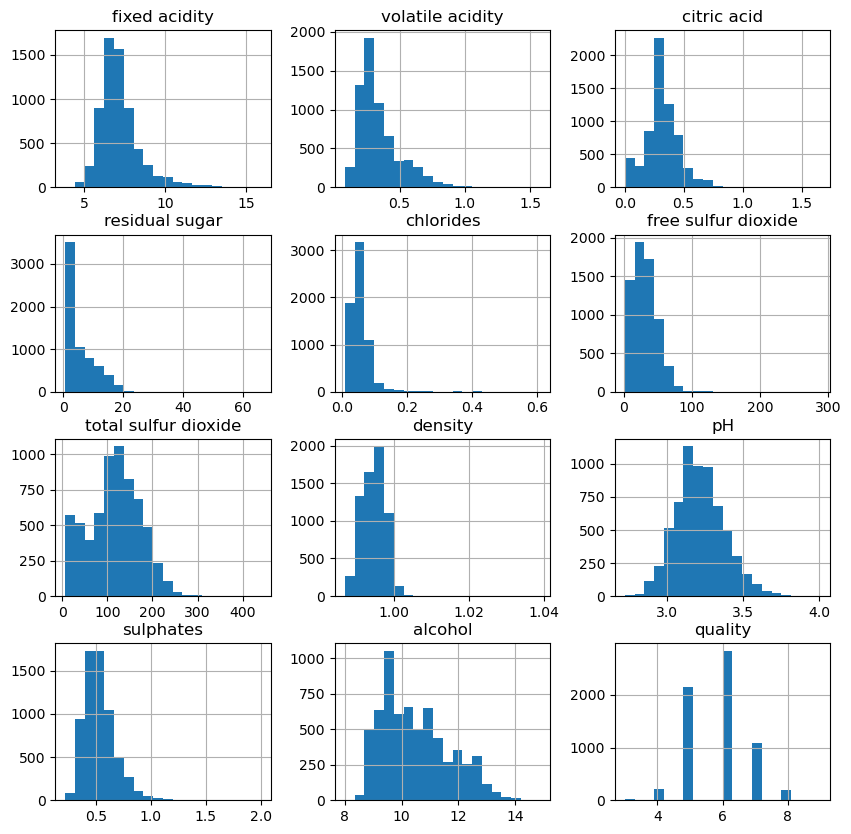

In [16]:
data.hist(bins=20, figsize=(10,10))
plt.show()

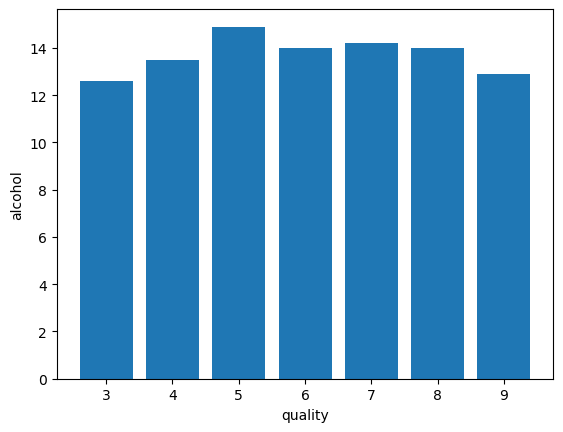

In [18]:
plt.bar(data['quality'], data['alcohol'])
plt.xlabel('quality')
plt.ylabel('alcohol')
plt.show()

### Correlation Matrix

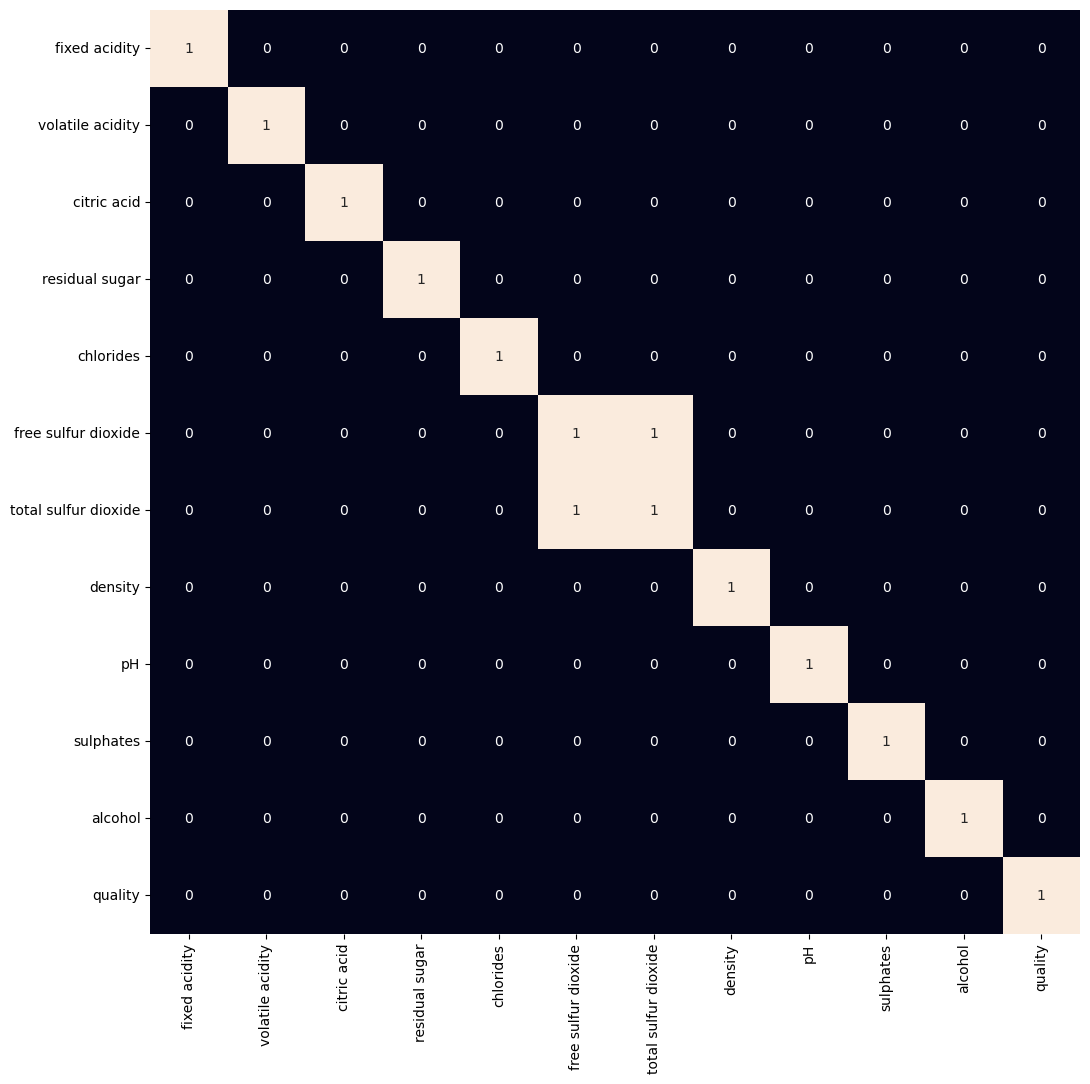

In [35]:
# # Convert 'object' columns to numerical if they represent numbers
# for col in data.columns:
#     if data[col].dtype == 'object':
#         try:
#             data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, replace non-convertibles with NaN
#         except:
#             pass  # Skip columns that cannot be converted

plt.figure(figsize=(12, 12))
sb.heatmap(data.corr() > 0.7, annot=True, cbar=False)
plt.show()

We see thst "total sulfur dioxide" and "free sulfur dioxide" are very highly correlated, which can skew our results. Therefore we remove both columns.

In [101]:
data = data.drop('total sulfur dioxide', axis=1)
data = data.drop('free sulfur dioxide', axis=1)

### Assigning a threshold for best quality and making it a 2-class classification problem

* Notes: Tried changing the threshold of 5 to 8 and 4. For some reason all models overfit or underfit. Reason must be because of the number of samples that get created in the train and test sets. 

In [102]:
data['best_quality'] = [1 if x > 5 else 0 for x in data.quality]

### Changing the `object` type features into numerical

In [103]:
data.replace({'white': 1, 'red': 0}, inplace=True)

In [104]:
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,density,pH,sulphates,alcohol,quality,best_quality
0,1,7.0,0.270,0.36,20.7,0.045,1.00100,3.00,0.450000,8.8,6,1
1,1,6.3,0.300,0.34,1.6,0.049,0.99400,3.30,0.490000,9.5,6,1
2,1,8.1,0.280,0.40,6.9,0.050,0.99510,3.26,0.440000,10.1,6,1
3,1,7.2,0.230,0.32,8.5,0.058,0.99560,3.19,0.400000,9.9,6,1
4,1,7.2,0.230,0.32,8.5,0.058,0.99560,3.19,0.400000,9.9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0,6.2,0.600,0.08,2.0,0.090,0.99490,3.45,0.580000,10.5,5,0
6493,0,5.9,0.550,0.10,2.2,0.062,0.99512,3.52,0.531215,11.2,6,1
6494,0,6.3,0.510,0.13,2.3,0.076,0.99574,3.42,0.750000,11.0,6,1
6495,0,5.9,0.645,0.12,2.0,0.075,0.99547,3.57,0.710000,10.2,5,0


### Split into train and test datasets

In [105]:
X = data.iloc[:, :-2]
y = data.iloc[:,-1]

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputing missing values

In [107]:
# Impute missing values after splitting
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Or another strategy like 'median'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train.shape, X_test.shape

((5197, 10), (1300, 10))

### Normalizing the features

In [108]:
norm = MinMaxScaler()
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

### Model fitting

In [109]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf')]

for model in models:
    print(f'{model}')
    model.fit(X_train, y_train)
    print(f'Training Accuracy : {round(accuracy_score(y_train, model.predict(X_train)), 5)}')
    print(f'Test Accuracy : {round(accuracy_score(y_test, model.predict(X_test)), 5)}\n')
          
    

LogisticRegression()
Training Accuracy : 0.73927
Test Accuracy : 0.75154

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training Accuracy : 0.97614
Test Accuracy : 0.81154

SVC()
Training Accuracy : 0.74947
Test Accuracy : 0.75615



The XGB model fits very well on the training set but does not do as well on the test set. This is a sign of overfitting. Therefore we cannot use this model. 

The Logistic Regression and SVC models have a lower accuracy score, but fit the data very well between the train and test sets. We will choose the SVC model to make predictions.


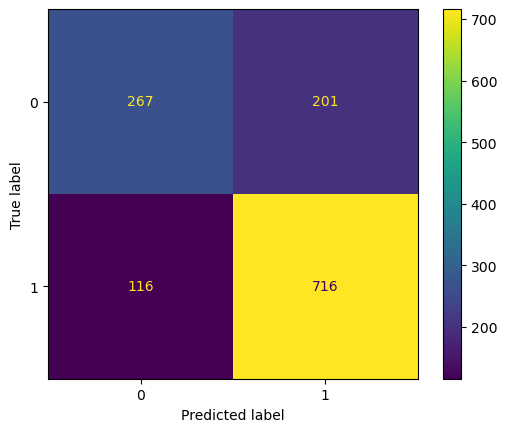

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, models[-1].predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[1].classes_)
disp.plot()
plt.show()